## Analysis of FF Endometrial Adenocarcinoma Dataset

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import seaborn as sns
import squidpy as sq
import csv
from sklearn.metrics.pairwise import cosine_distances

plt.rcParams['figure.figsize']=(8,8)


%load_ext autoreload
%autoreload 2


### First pre-process data with scanpy

In [2]:
##Load in data
ff_human_ovarian_cancer = sc.datasets.visium_sge('Parent_Visium_Human_OvarianCancer')
ff_human_ovarian_cancer.var_names_make_unique()

100%|██████████████████████████████████████| 6.84M/6.84M [00:02<00:00, 3.03MB/s]
100%|██████████████████████████████████████| 16.1M/16.1M [00:15<00:00, 1.09MB/s]
/Users/nataliecharitakis/opt/anaconda3/envs/squidpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
ff_human_ovarian_cancer

AnnData object with n_obs × n_vars = 3493 × 36601
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [4]:
#Calculate some QC metrics for the data
ff_human_ovarian_cancer.var["mt"] = ff_human_ovarian_cancer.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(ff_human_ovarian_cancer, qc_vars=["mt"], inplace=True)

In [5]:
##Filter by MT values
ff_human_ovarian_cancer = ff_human_ovarian_cancer[ff_human_ovarian_cancer.obs["pct_counts_mt"] < 15]
ff_human_ovarian_cancer = ff_human_ovarian_cancer[ff_human_ovarian_cancer.obs["pct_counts_mt"] > 2]

In [6]:
ff_human_ovarian_cancer.var["mt"]
ff_human_ovarian_cancer.var.sort_values(by=['mt'])

gene_ids    feature_types  genome     mt  \
MIR1302-2HG  ENSG00000243485  Gene Expression  GRCh38  False   
RAB15        ENSG00000139998  Gene Expression  GRCh38  False   
GPX2         ENSG00000176153  Gene Expression  GRCh38  False   
CHURC1       ENSG00000258289  Gene Expression  GRCh38  False   
SPTB         ENSG00000070182  Gene Expression  GRCh38  False   
...                      ...              ...     ...    ...   
MT-ND1       ENSG00000198888  Gene Expression  GRCh38   True   
MT-ND6       ENSG00000198695  Gene Expression  GRCh38   True   
MT-CYB       ENSG00000198727  Gene Expression  GRCh38   True   
MT-ND4       ENSG00000198886  Gene Expression  GRCh38   True   
MT-ATP6      ENSG00000198899  Gene Expression  GRCh38   True   

             n_cells_by_counts  mean_counts  log1p_mean_counts  \
MIR1302-2HG                  0     0.000000           0.000000   
RAB15                      214     0.065273           0.063231   
GPX2                         2     0.000573           0.000572   
CHURC1                    1818     0.846837           0.613474   
SPTB                        16     0.004867           0.004855   
...                        ...          ...                ...   
MT-ND1                    3493    72.984543           4.303856   
MT-ND6                     238     0.073862           0.071262   
MT-CYB                    3489    34.320927           3.564476   
MT-ND4                    3493    90.724876           4.518794   
MT-ATP6                   3490    47.426281           3.880043   

             pct_dropout_by_counts  total_counts  log1p_total_counts  
MIR1302-2HG             100.000000           0.0            0.000000  
RAB15                    93.873461         228.0            5.433722  
GPX2                     99.942743           2.0            1.098612  
CHURC1                   47.953049        2958.0            7.992607  
SPTB                     99.541941          17.0            2.890372  
...                            ...           ...                 ...  
MT-ND1                    0.000000      254935.0           12.448768  
MT-ND6                   93.186373         258.0            5.556828  
MT-CYB                    0.114515      119883.0           11.694280  
MT-ND4                    0.000000      316902.0           12.666351  
MT-ATP6                   0.085886      165660.0           12.017699  

[36601 rows x 10 columns]

In [7]:
ff_human_ovarian_cancer.obs

in_tissue  array_row  array_col  n_genes_by_counts  \
AAACAAGTATCTCCCA-1          1         50        102               2460   
AAACACCAATAACTGC-1          1         59         19               3842   
AAACAGGGTCTATATT-1          1         47         13               3840   
AAACATTTCCCGGATT-1          1         61         97               2638   
AAACCCGAACGAAATC-1          1         45        115               3770   
...                       ...        ...        ...                ...   
TTGTTCAGTGTGCTAC-1          1         24         64               5374   
TTGTTGTGTGTCAAGA-1          1         31         77               4085   
TTGTTTCACATCCAGG-1          1         58         42               3210   
TTGTTTCATTAGTCTA-1          1         60         30               2831   
TTGTTTCCATACAACT-1          1         45         27               5694   

                    log1p_n_genes_by_counts  total_counts  log1p_total_counts  \
AAACAAGTATCTCCCA-1                 7.808323        4752.0            8.466531   
AAACACCAATAACTGC-1                 8.254009       10543.0            9.263312   
AAACAGGGTCTATATT-1                 8.253488       10174.0            9.227689   
AAACATTTCCCGGATT-1                 7.878155        5198.0            8.556222   
AAACCCGAACGAAATC-1                 8.235095        8803.0            9.082961   
...                                     ...           ...                 ...   
TTGTTCAGTGTGCTAC-1                 8.589514       15281.0            9.634431   
TTGTTGTGTGTCAAGA-1                 8.315322       10426.0            9.252154   
TTGTTTCACATCCAGG-1                 8.074338        7732.0            8.953252   
TTGTTTCATTAGTCTA-1                 7.948738        6291.0            8.747034   
TTGTTTCCATACAACT-1                 8.647344       19213.0            9.863395   

                    pct_counts_in_top_50_genes  pct_counts_in_top_100_genes  \
AAACAAGTATCTCCCA-1                   23.106061                    31.439394   
AAACACCAATAACTGC-1                   29.887129                    38.594328   
AAACAGGGTCTATATT-1                   26.567722                    34.824061   
AAACATTTCCCGGATT-1                   22.912659                    30.377068   
AAACCCGAACGAAATC-1                   18.118823                    26.684085   
...                                        ...                          ...   
TTGTTCAGTGTGCTAC-1                   17.374517                    25.914534   
TTGTTGTGTGTCAAGA-1                   22.817955                    32.284673   
TTGTTTCACATCCAGG-1                   23.629074                    33.484221   
TTGTTTCATTAGTCTA-1                   26.100779                    33.635352   
TTGTTTCCATACAACT-1                   21.167959                    31.202831   

                    pct_counts_in_top_200_genes  pct_counts_in_top_500_genes  \
AAACAAGTATCTCCCA-1                    40.551347                    55.239899   
AAACACCAATAACTGC-1                    46.618610                    57.839325   
AAACAGGGTCTATATT-1                    42.815019                    55.258502   
AAACATTTCCCGGATT-1                    39.399769                    53.982301   
AAACCCGAACGAAATC-1                    35.681018                    49.733046   
...                                         ...                          ...   
TTGTTCAGTGTGCTAC-1                    34.742491                    47.411819   
TTGTTGTGTGTCAAGA-1                    40.974487                    53.318627   
TTGTTTCACATCCAGG-1                    42.964304                    56.492499   
TTGTTTCATTAGTCTA-1                    42.298522                    56.302655   
TTGTTTCCATACAACT-1                    40.071826                    52.089731   

                    total_counts_mt  log1p_total_counts_mt  pct_counts_mt  
AAACAAGTATCTCCCA-1            393.0               5.976351       8.270202  
AAACACCAATAACTGC-1           1436.0               7.270313      13.620413  
AAACAGGGTCTATATT-1  

<IPython.core.display.Javascript object>


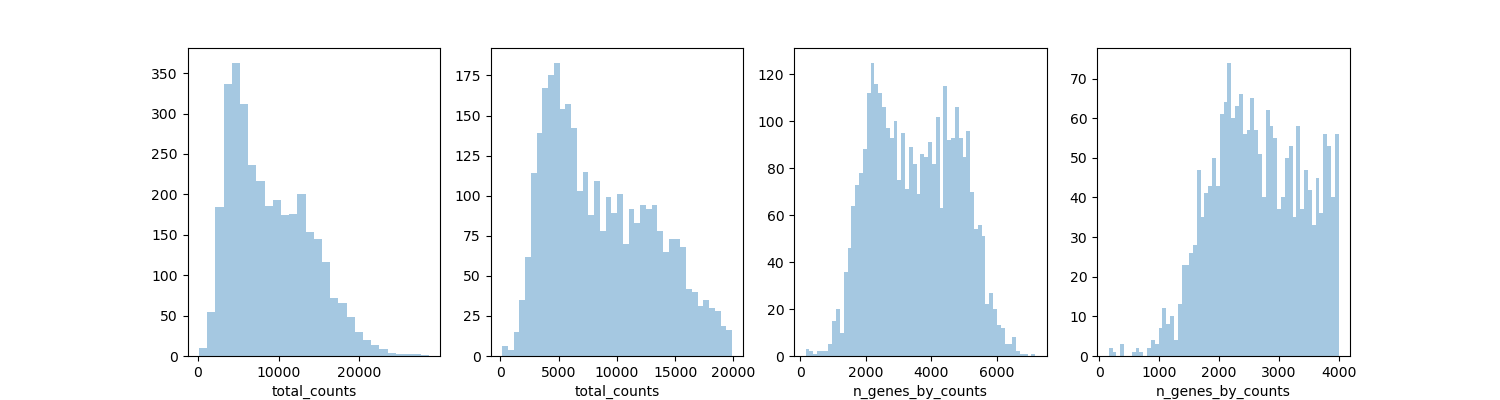

/var/folders/z2/blpwq8wx3p37k5lbxzs9vyf80000gn/T/ipykernel_2536/2247817540.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ff_human_ovarian_cancer.obs["total_counts"], kde=False, ax=axs[0])
/var/folders/z2/blpwq8wx3p37k5lbxzs9vyf80000gn/T/ipykernel_2536/2247817540.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad637275

<IPython.core.display.Javascript object>


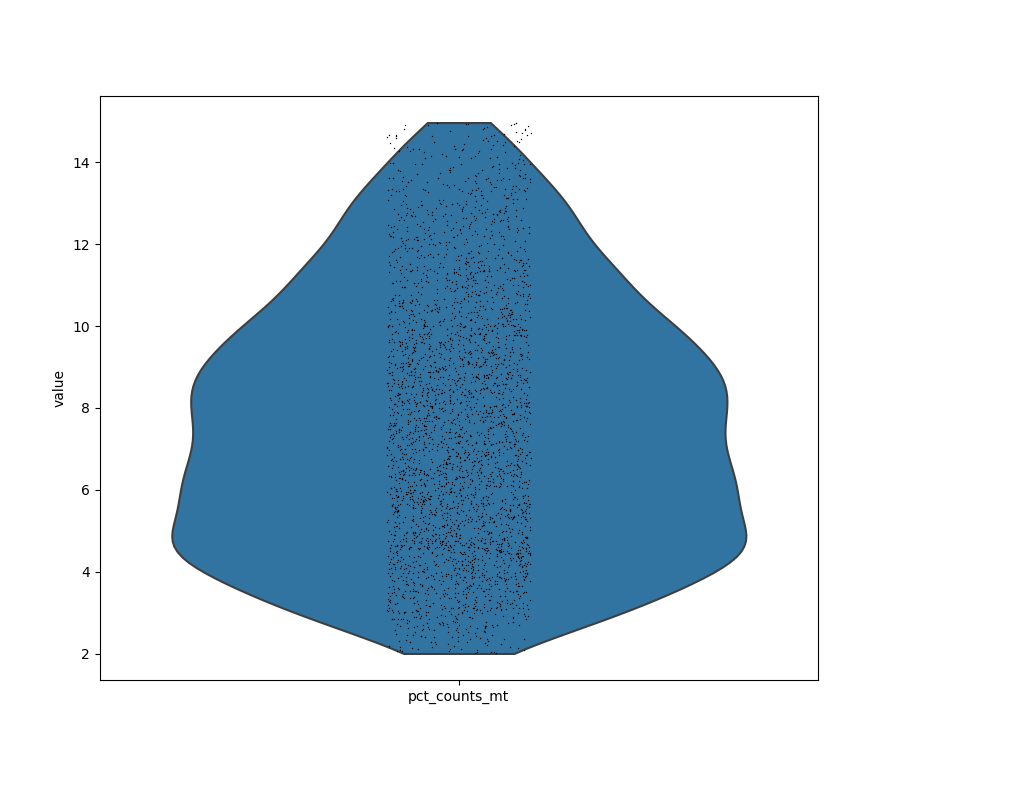

In [8]:
#Visualise some QC metrics for the data
%matplotlib notebook

fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(ff_human_ovarian_cancer.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(ff_human_ovarian_cancer.obs["total_counts"][ff_human_ovarian_cancer.obs["total_counts"] < 20000], kde=False, bins=40, ax=axs[1])
sns.distplot(ff_human_ovarian_cancer.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(ff_human_ovarian_cancer.obs["n_genes_by_counts"][ff_human_ovarian_cancer.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])
sc.pl.violin(ff_human_ovarian_cancer,['pct_counts_mt'])

In [9]:
ff_human_ovarian_cancer

AnnData object with n_obs × n_vars = 3326 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

In [10]:
#Perform some filtering
sc.pp.filter_cells(ff_human_ovarian_cancer, min_counts=2000)
print(f'Number of cells after min count filter: {ff_human_ovarian_cancer.n_obs}')
sc.pp.filter_cells(ff_human_ovarian_cancer, max_counts=20000)
print(f'Number of cells after max count filter: {ff_human_ovarian_cancer.n_obs}')
ff_human_ovarian_cancer = ff_human_ovarian_cancer[ff_human_ovarian_cancer.obs["pct_counts_mt"] < 15]
ff_human_ovarian_cancer = ff_human_ovarian_cancer[ff_human_ovarian_cancer.obs["pct_counts_mt"] > 2]
print(f"#cells after MT filter: {ff_human_ovarian_cancer.n_obs}")
#Filter out genes that are detected in less than 10 cells
sc.pp.filter_genes(ff_human_ovarian_cancer, min_cells=10)
print(f'Number of genes after cell filter: {ff_human_ovarian_cancer.n_vars}')
sc.pp.filter_cells(ff_human_ovarian_cancer, min_genes = 2000)
print(f'Number of cells after gene filter: {ff_human_ovarian_cancer.n_obs}')

Number of cells after min count filter: 3275
Number of cells after max count filter: 3207
#cells after MT filter: 3207
Number of genes after cell filter: 17795
Number of cells after gene filter: 2837


/Users/nataliecharitakis/opt/anaconda3/envs/squidpy/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [11]:
##Do normalisation and find highly variable genes
sc.pp.normalize_total(ff_human_ovarian_cancer, inplace=True)
sc.pp.log1p(ff_human_ovarian_cancer)
sc.pp.highly_variable_genes(ff_human_ovarian_cancer, flavor="seurat", n_top_genes=2000)

<IPython.core.display.Javascript object>


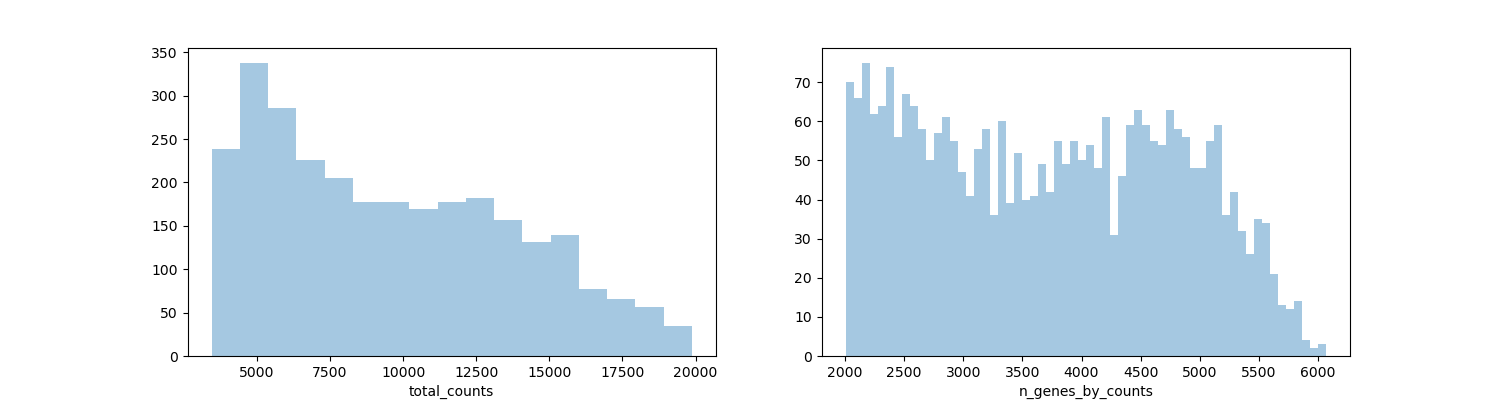

/var/folders/z2/blpwq8wx3p37k5lbxzs9vyf80000gn/T/ipykernel_2536/3170637962.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ff_human_ovarian_cancer.obs["total_counts"], kde=False, ax=axs[0])
/var/folders/z2/blpwq8wx3p37k5lbxzs9vyf80000gn/T/ipykernel_2536/3170637962.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad637275

<AxesSubplot: xlabel='n_genes_by_counts'>

In [12]:
#Look at same plots after filtering an normalisation
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.distplot(ff_human_ovarian_cancer.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(ff_human_ovarian_cancer.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[1])

In [13]:
#Perform next steps in cluster identification
sc.pp.pca(ff_human_ovarian_cancer,n_comps=20)
sc.pp.neighbors(ff_human_ovarian_cancer)
sc.tl.umap(ff_human_ovarian_cancer)
sc.tl.leiden(ff_human_ovarian_cancer, key_added='clusters')

/Users/nataliecharitakis/opt/anaconda3/envs/squidpy/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<IPython.core.display.Javascript object>


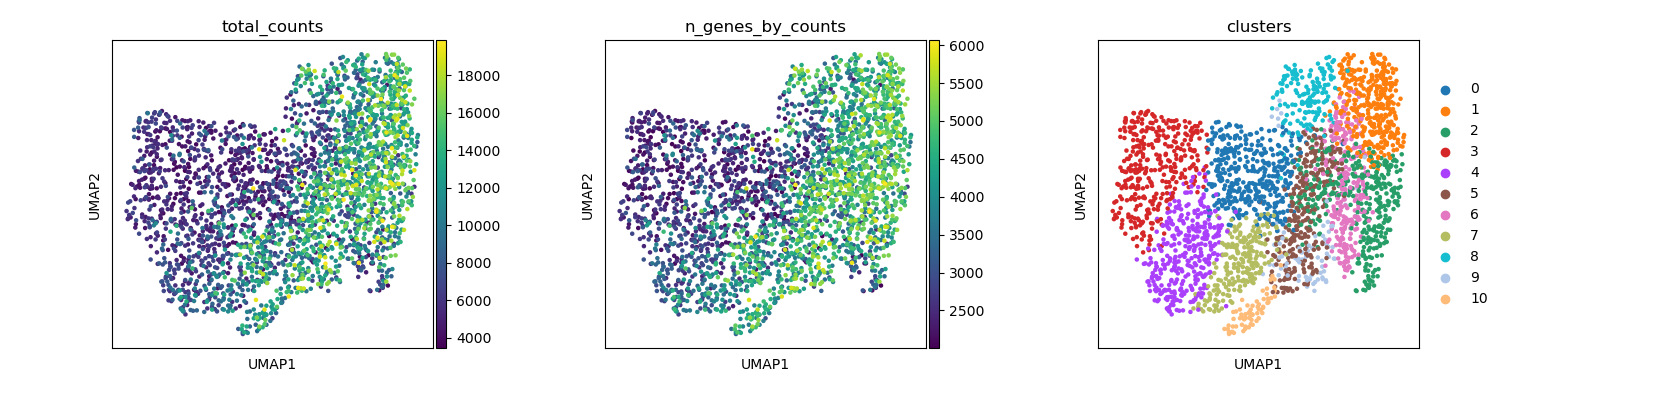

/Users/nataliecharitakis/opt/anaconda3/envs/squidpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


In [14]:
#Plot UMAPs
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(ff_human_ovarian_cancer, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

<IPython.core.display.Javascript object>


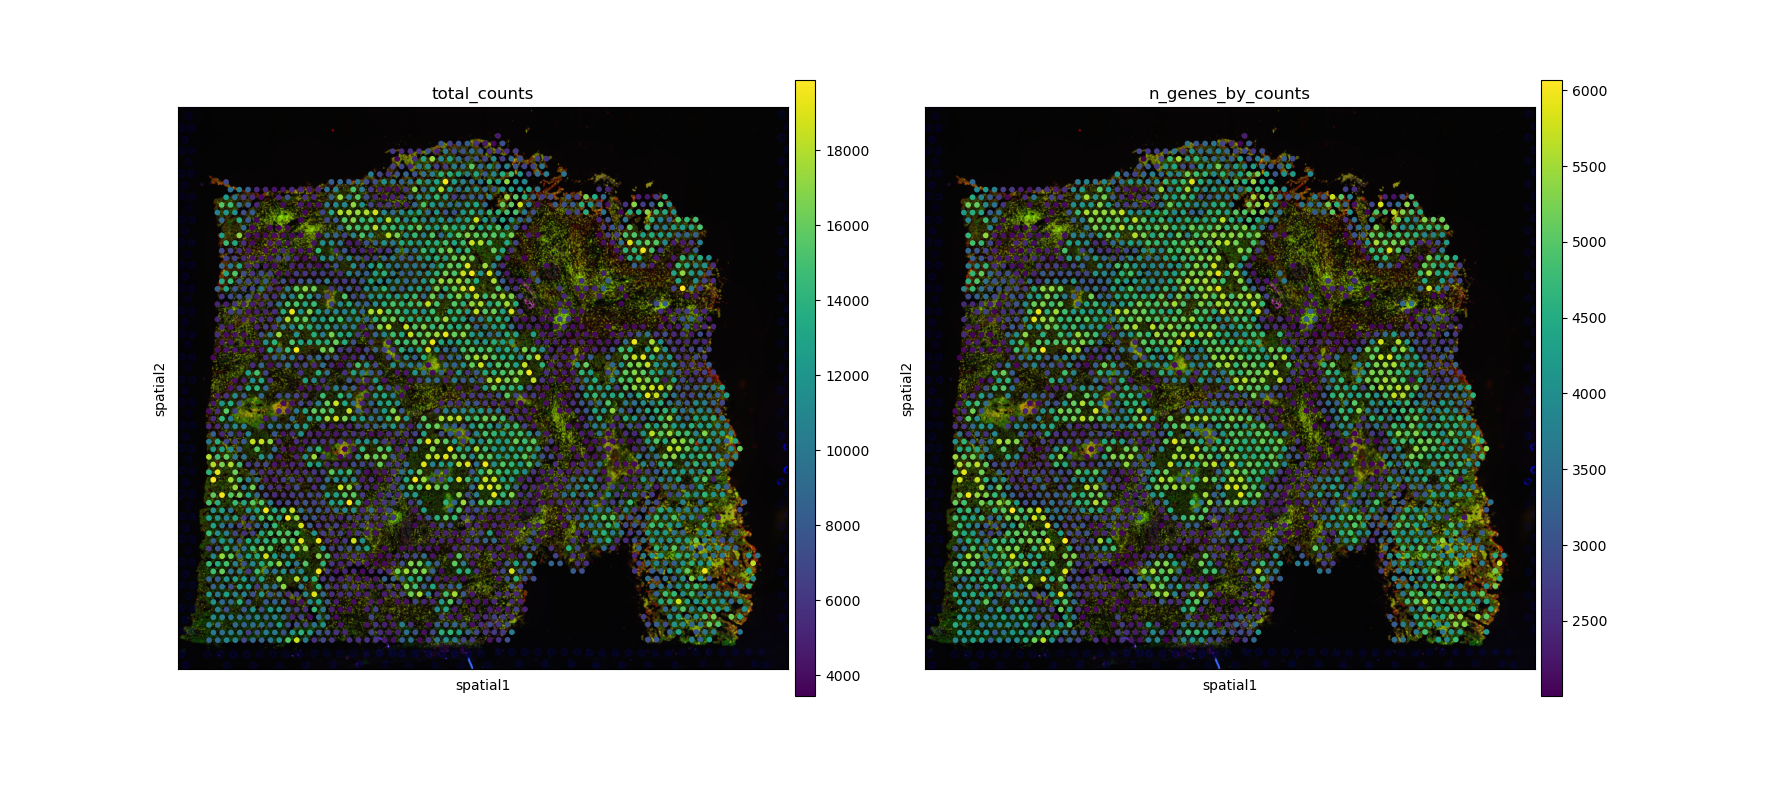

In [15]:
#Visualise metrics in spatial coordinates
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(ff_human_ovarian_cancer, img_key="hires", color=["total_counts", "n_genes_by_counts"])

<IPython.core.display.Javascript object>


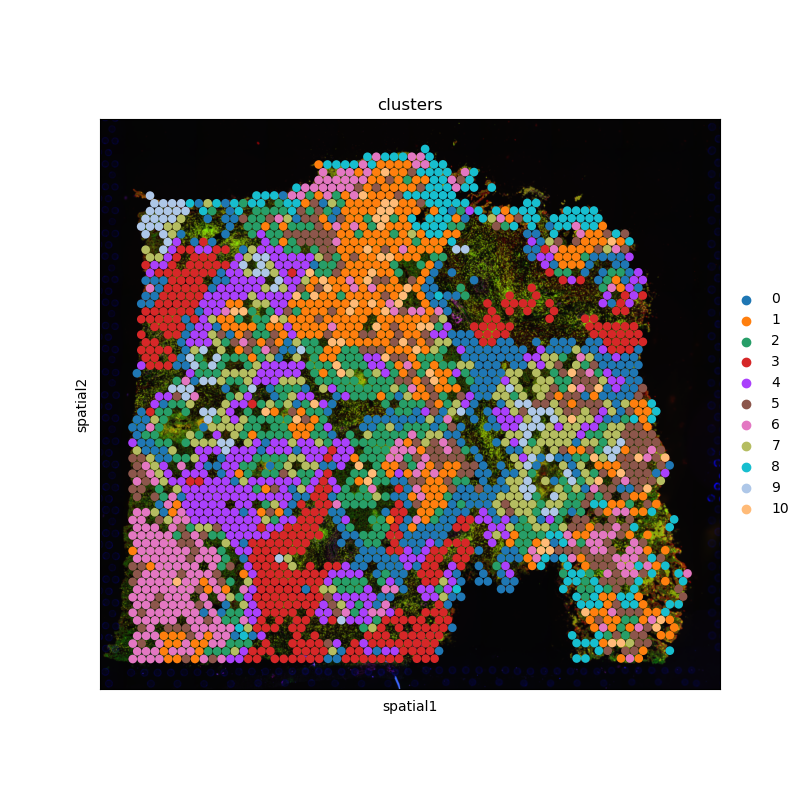

In [16]:
#Visualise cell type clusters on image of. tissue
sc.pl.spatial(ff_human_ovarian_cancer, img_key="hires", color="clusters", size=1.5)

<IPython.core.display.Javascript object>


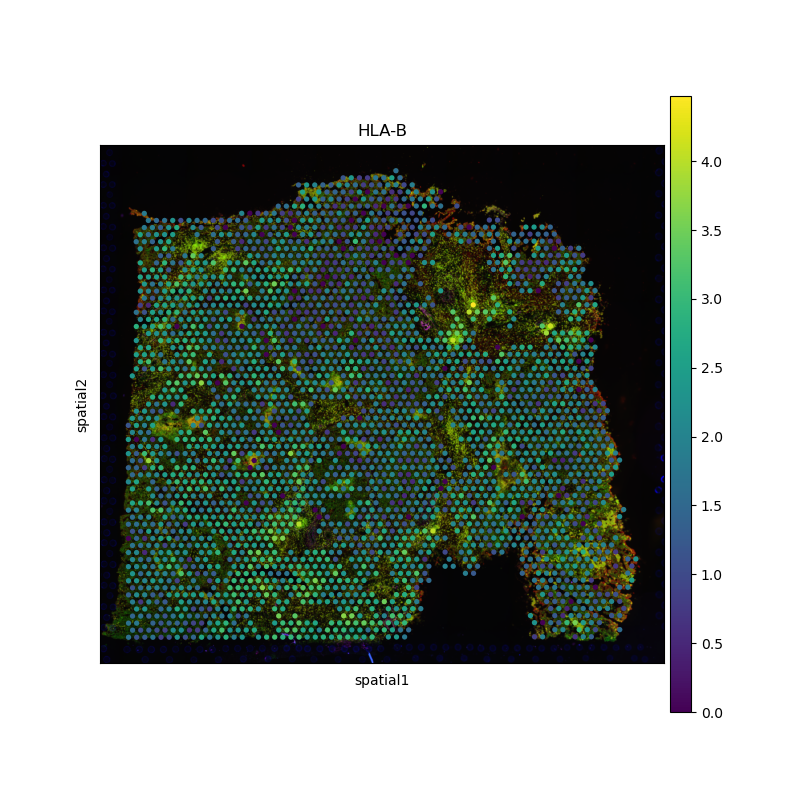

In [17]:
#Visualise expression of a particular gene across tissue
sc.pl.spatial(ff_human_ovarian_cancer, img_key = "hires", color="HLA-B")

### Now perform SVG analysis with Squidpy

In [18]:
##Run moran's I on all genes in dataset
sq.gr.spatial_neighbors(ff_human_ovarian_cancer, coord_type="generic", delaunay=True)
sq.gr.spatial_autocorr(ff_human_ovarian_cancer, genes=ff_human_ovarian_cancer.var_names, use_raw=False, mode="moran")
ff_human_ovarian_cancer.uns["moranI"].head(10)

I  pval_norm  var_norm  pval_norm_fdr_bh
IGHG4   0.776498        0.0  0.000118               0.0
IGKC    0.774099        0.0  0.000118               0.0
IGHG3   0.754957        0.0  0.000118               0.0
IGLC2   0.688609        0.0  0.000118               0.0
IGHA1   0.688435        0.0  0.000118               0.0
MALAT1  0.670346        0.0  0.000118               0.0
IGLC1   0.663894        0.0  0.000118               0.0
IGHG1   0.662533        0.0  0.000118               0.0
MT-CO1  0.647152        0.0  0.000118               0.0
MT-ND1  0.634318        0.0  0.000118               0.0

In [19]:
moran_I = pd.DataFrame(ff_human_ovarian_cancer.uns['moranI'].sort_values(ascending=False,by=['I']))

##Sort this so corrected pvalue is above 0.05 and I is above 0.5
moran_I = moran_I[moran_I['pval_norm_fdr_bh'] <=0.05]
moran_I = moran_I[moran_I['I'] > 0]

##Write out results
moran_I.to_csv("ff_human_ovarian_cancer_squidpy_moranI_results_pval_fdr_bh_0.05_moransI_positive.csv")